# D213: Advanced Data Analytics – Task 1 Time Series Modeling
## Part I: Research Question
### A1. Research Question
Is it possible to predict the daily revenue for the next quarter of the telecommunications company based on the daily revenue from the first two years of operation? 

### A2. Goal of the Analysis
The goal of this analysis is to build a predictive model that will forecast the future revenue of a telecommunications company for the next quarter.

## Part II: Method Justification
### B. Assumptions Summary
1. Stationarity: This assumption in a time series model is that the data is stationary. This means that the time series properties do not change over a certain time period and the mean, variance, and autocorrection also remain constant.
2. Autocorrelation: This assumption in a time series model is that the data has no correlation to the past. A high autocorrelation indicates the past values could help forecast present and futures values (Elleh, n.d.).

## Part III: Data Preparation

In [1]:
# Import the necessary packages & libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error 
from scipy import signal

# Ignore warning code
import warnings
warnings.filterwarnings('ignore')

# Load the data set into the pandas data frame by using read_csv command
df = pd.read_csv(r'C:\Users\ashle\Downloads\D213\teleco_time_series.csv')

# Explore the dataset
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [3]:
df.shape

(731, 2)

In [4]:
# Calculate total null values and total duplicate values in the dataset
total_nulls = df.isna().sum().sum()
total_dupes = df.duplicated().sum()

print(f"Total Nulls: {total_nulls}\nTotal Duplicate Records: {total_dupes}")

Total Nulls: 0
Total Duplicate Records: 0


### C1. Line Graph Visualization

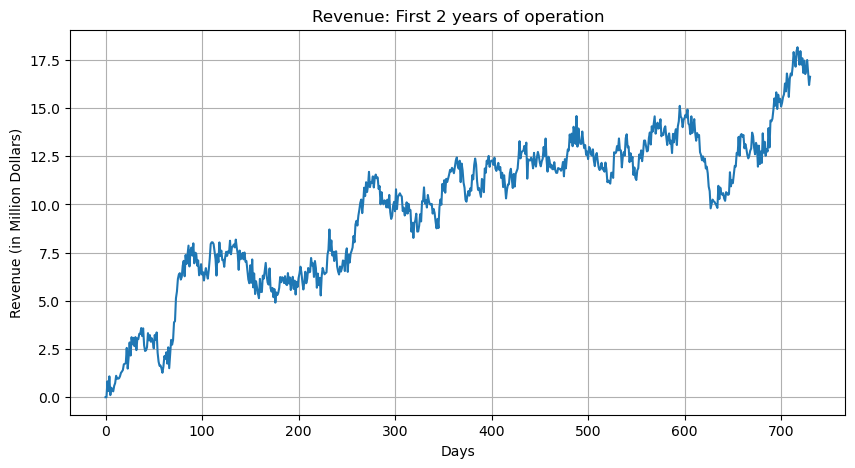

In [5]:
# Visualize the realization of time series
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Revenue: First 2 years of operation')
plt.xlabel('Days')
plt.ylabel('Revenue (in Million Dollars)')
plt.grid(True)
plt.show()

### C2. Time Step Format
The dataset has two columns, “Day” and “Revenue” and 731 rows. To prepare the dataset for time series analysis, we must check for gaps in the measurements and duplicates/missing data. In this case, there weren’t any gaps and there was no missing data or duplicates. The next step is to convert "Day" to "Date" because time series models favor a date structure.

In [6]:
# Convert "Day" to DateTime format because time series models favor a date structure
df['Day'] = (pd.date_range(start=datetime(2019,1,1),
                            periods=df.shape[0], freq='D'))

# Set Day as an index
df.set_index('Day', inplace=True)
df

,Revenue
Day,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554
...,...
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638


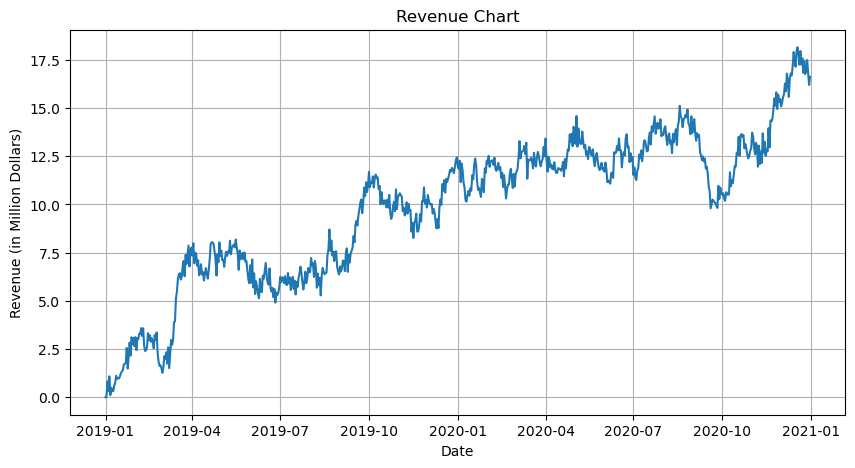

In [7]:
# Visualize the data
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue (in Million Dollars)')
plt.grid(True)
plt.show()

### C3. Stationarity
The provided dataset was non-stationary based on the upward trend shown on the line graph in part C1. This was further proven using the Augmented Dicker-Fuller (Adfuller) test since the p-value was 0.32 which is greater than 0.05, failing to reject the null hypothesis. 
- Null Hypothesis = Time series is non-stationary 
- Alternative Hypothesis = Time series is stationary

In [8]:
# Check for stationarity using Adfuller Test
result = adfuller(df['Revenue'])
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -1.9246121573101846
p-value:  0.32057281507939595
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [9]:
# Null Hypothesis = Time series is non-stationary 
# Alternative Hypothesis = Time series is stationary

if result[1] <= 0.05: 
    print("Reject null hypothesis, the time series is stationary")
else: 
    print("Fail to reject null hypothesis, the time series is non-stationary")

Fail to reject null hypothesis, the time series is non-stationary


Since the data is non-stationary, differencing must be performed by calculating the difference between the past and present observations. Essentially, this method transforms the non-stationary data to a stationary time series by getting rid of seasonal patterns and trends to stabilize the mean (Elleh, n.d.).

In [10]:
# Since time series is non-stationary, conduct first order differencing
df_diff = df.diff()
df_diff.head()

,Revenue
Day,
2019-01-01,NaN
2019-01-02,0.000793
2019-01-03,0.824749
2019-01-04,-0.505210
2019-01-05,0.762222


In [11]:
# Check for stationarity using Adfuller Test again
result = adfuller(df_diff['Revenue'].dropna())
print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[1] <= 0.05: 
    print("Reject null hypothesis, the time series is stationary")
else: 
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test statistics:  -44.87452719387598
p-value:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


In [12]:
# Split data 80-20
X_train = df.iloc[:585]
X_test = df.iloc[585:]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (585, 1)
X_test Shape (146, 1)


### C4. Steps for Data Preparation
1. Import the necessary packages & libraries.
2. Load the data set into the pandas data frame by using read_csv command.
3. Explore the dataset.
4. Calculate total null values and total duplicate values in the dataset.
5. Convert "Day" to "Date" because time series models favor a date structure. Set the "Date" as an index.
6. Visualize the data by performing EDA.
7. Check for stationarity using Adfuller Test. If it is non-stationary, perform differencing.
8. Split the data into training and testing sets.

### C5. Prepared Dataset
The csv files will be attached to submission.

In [13]:
# Export the prepared datset to csv file
df.to_csv('D213_prepared1.csv')
df_diff.to_csv('D213_difference1.csv')

# Export train and test sets to csv files
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')

## Part IV: Model Identification & Analysis
### D1. Report Findings and Visualizations
#### The presence or lack of a seasonal component

<Axes: title={'center': 'Seasonality'}, xlabel='Day'>

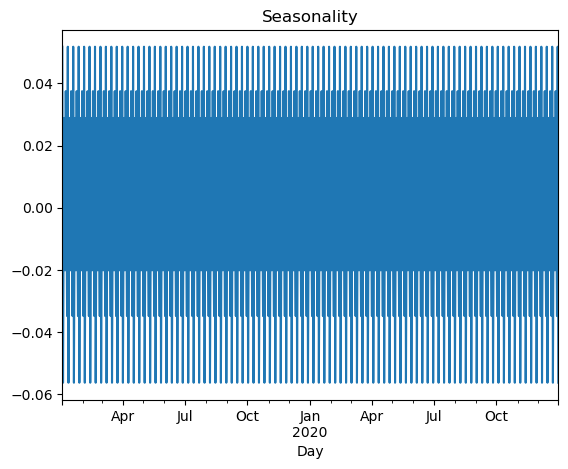

In [14]:
# Decompose the data (8 quarters in 2 years)
decomp = seasonal_decompose(df_diff.dropna(), period=8)

# Plot the seasonlity
plt.title('Seasonality')
decomp.seasonal.plot()

#### Trend

<Axes: title={'center': 'Trend'}, xlabel='Day'>

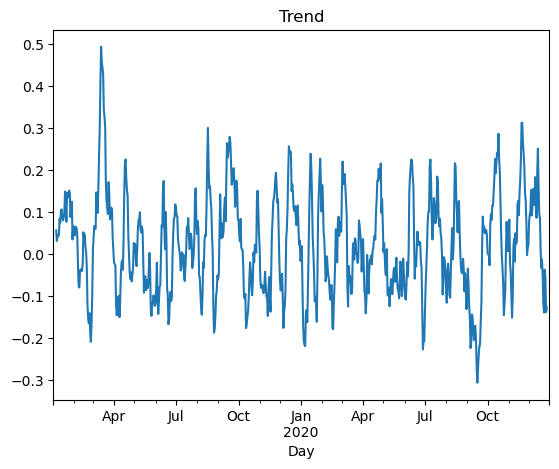

In [15]:
# Plot the time series showing the trend component
plt.title('Trend')
decomp.trend.plot()

#### The autocorrelation function

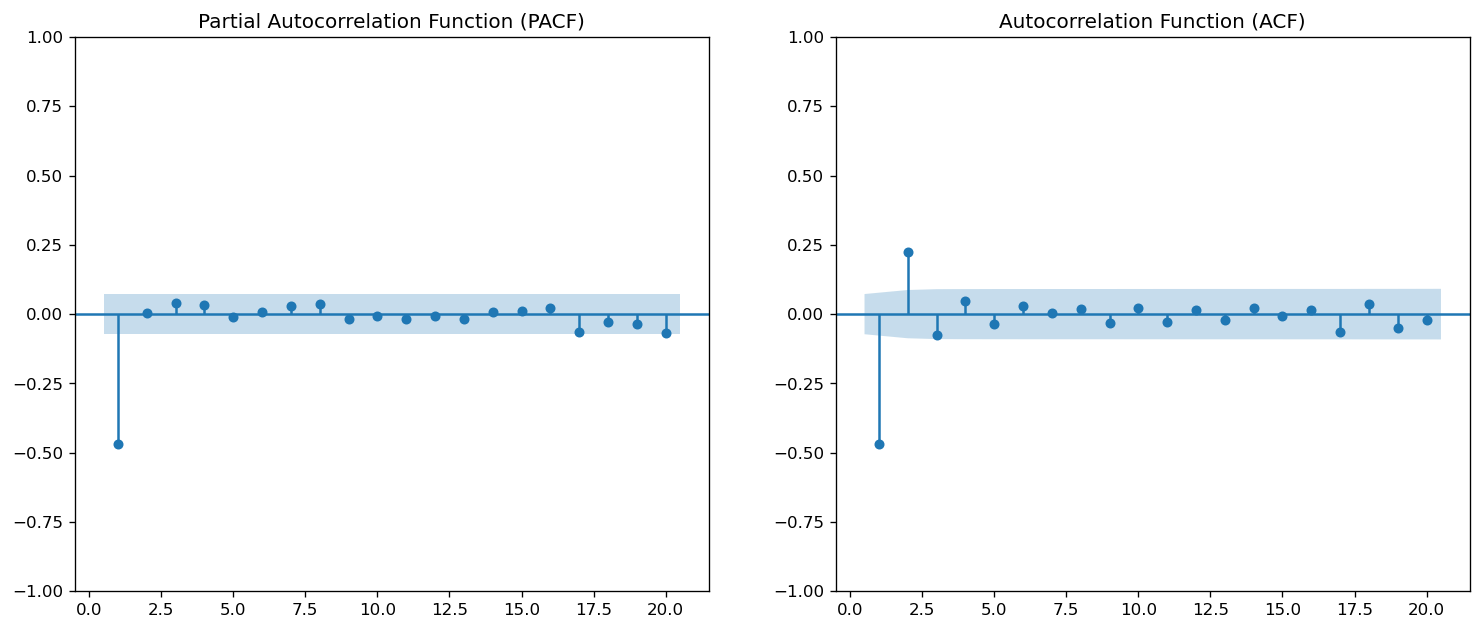

In [16]:
# Fix the size for all plots
plt.rcParams.update({'figure.figsize': (15, 6), 'figure.dpi': 120})

# PLot the partial autocorrelation & autocorrelation functions of the differenced data
fig, axes = plt.subplots(1, 2)

plot_pacf(df_diff.dropna(), lags=20, ax=axes[0], zero=False)
axes[0].set_title('Partial Autocorrelation Function (PACF)')

plot_acf(df_diff.dropna(), lags=20, ax=axes[1], zero=False)
axes[1].set_title('Autocorrelation Function (ACF)')

plt.show()

#### The spectral density

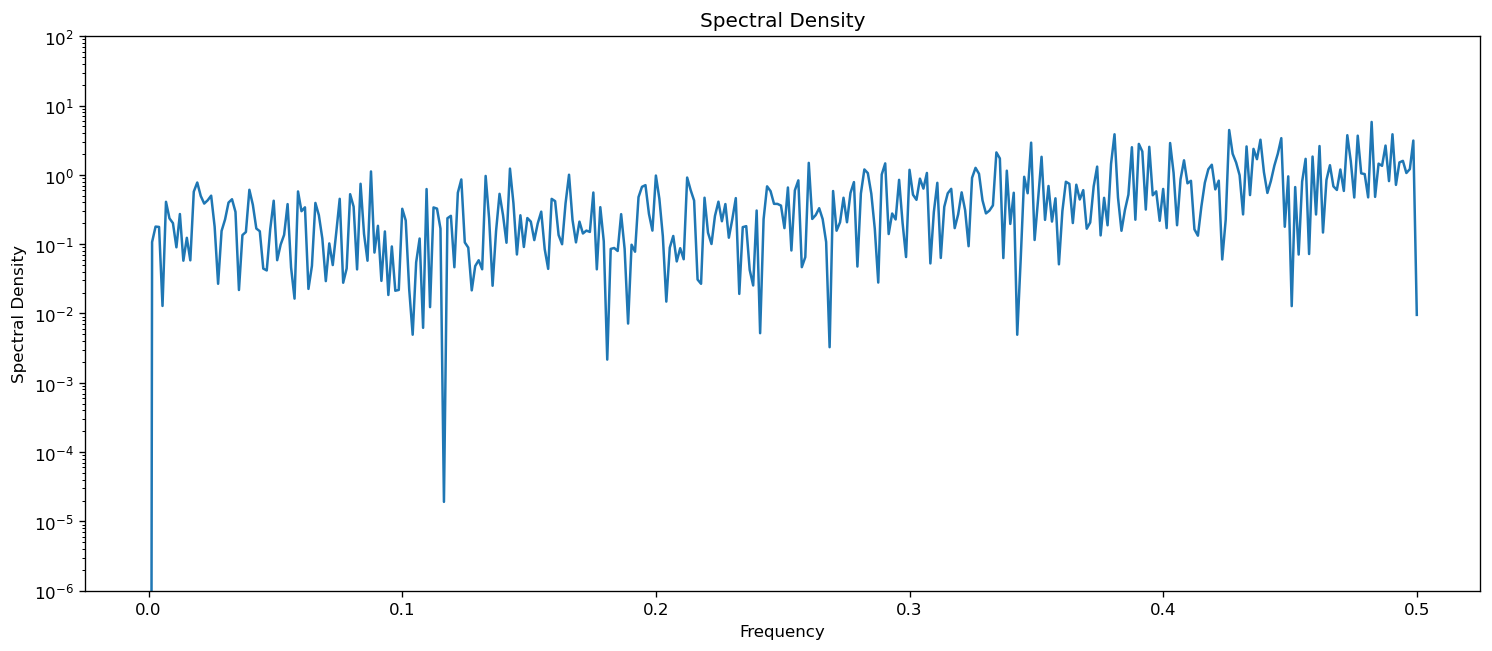

In [17]:
# Display the spectral density
f, Pxx_den = signal.periodogram(df_diff['Revenue'].dropna())
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

#### The decomposed time series

<Figure size 1200x1800 with 0 Axes>

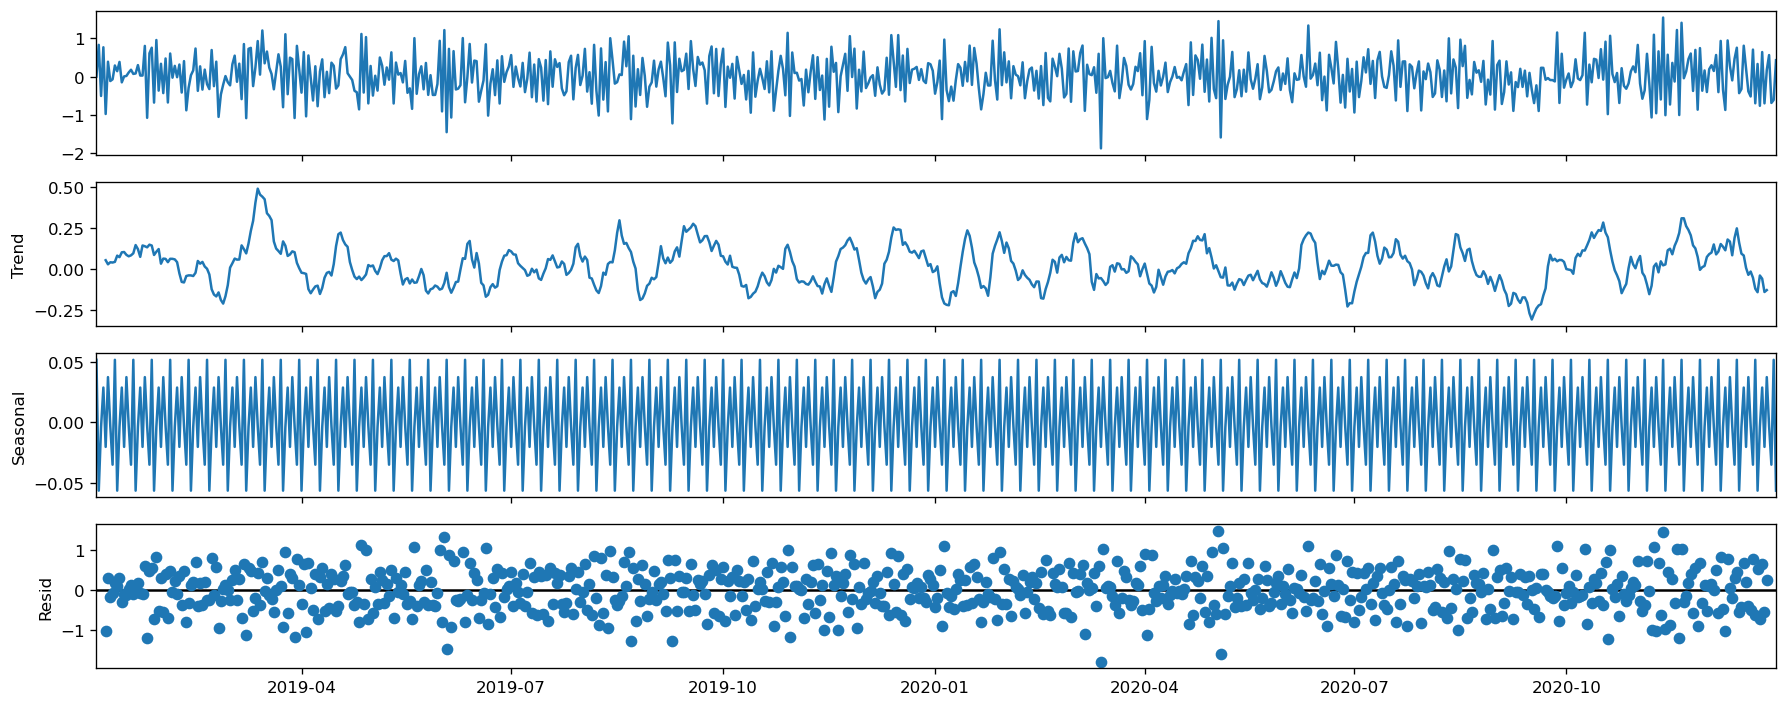

In [18]:
# Plot the decomposed time series data
plt.figure(figsize=(10,15))
decomp.plot()
plt.show()

#### Confirmation of the lack of trends in the residuals of the decomposed series

<Axes: title={'center': 'Residuals'}, xlabel='Day'>

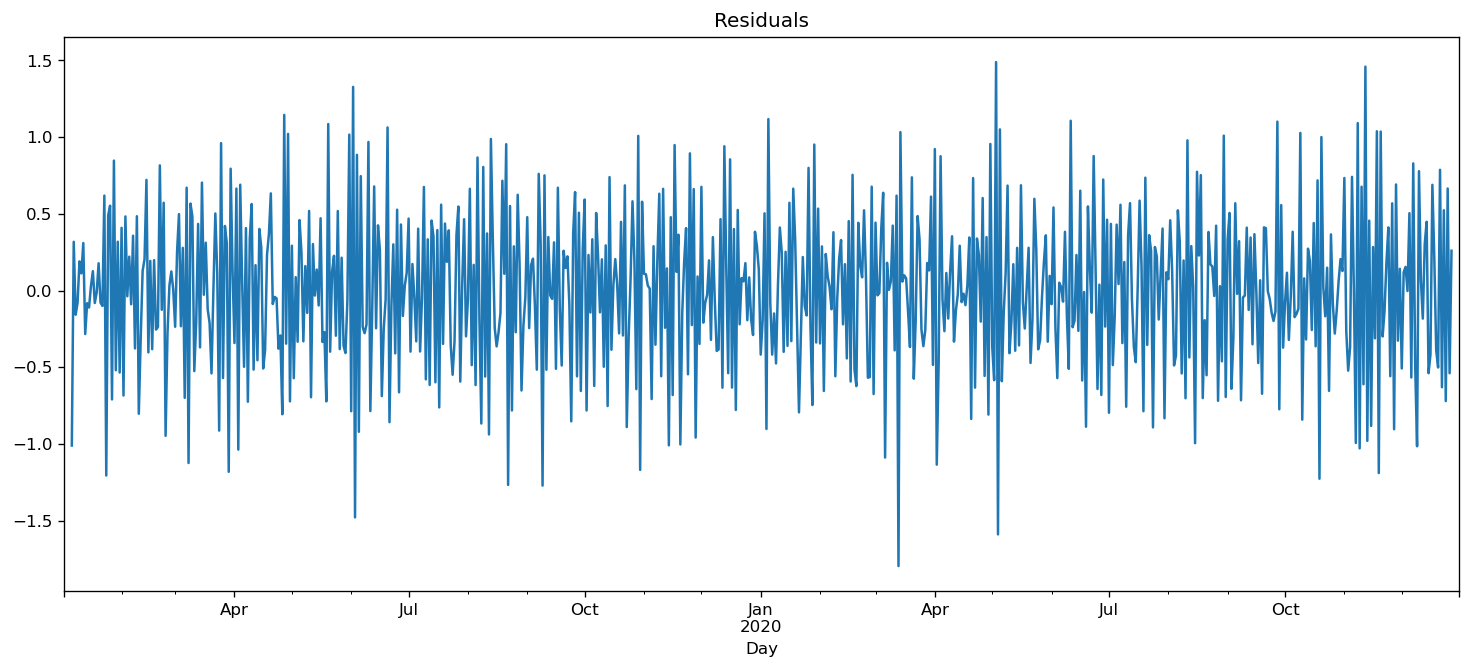

In [19]:
# Confirmation of the lack of trends in the residuals of the decomposed series
plt.title('Residuals')
decomp.resid.plot()

### D2. ARIMA Model

In [20]:
# Fit the auto_arima function to the differenced dataset
stepwise_fit = auto_arima(df_diff['Revenue'].dropna(), start_p=1, start_q=1, max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True, 
                          stepwise = True)   
# Print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1630.978, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1267.745, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1628.989, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1470.699, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1154.433, Time=0.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1351.604, Time=0.91 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1156.264, Time=0.96 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1156.304, Time=1.27 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1202.537, Time=0.91 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1153.406, Time=2.89 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  730
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood                -568.357
Date:                             Mon, 13 Jan 2025   AIC                           1150.713
Time:                                     14:01:42   BIC                           1182.749
Sample:                                 01-02-2019   HQIC                          1163.082
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1468      0.225      0.651      0.515      -0.295       0.589
ar.L2          0.3659      0.108      3.394      0.001       0.155       0.577
ar.L3          0.0700      0.043      1.612      0.107      -0.015       0.155
ma.L1         -0.6431      0.226     -2.848      0.004      -1.086      -0.201
ar.S.L12      -0.7138      0.038    -18.795      0.000      -0.788      -0.639
ar.S.L24      -0.3943      0.038    -10.419      0.000      -0.468      -0.320
sigma2         0.2820      0.016     18.062      0.000       0.251       0.313
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Create the SARIMAX model on the training set using the order just found
model_train = SARIMAX(X_train['Revenue'],  
                order = (3, 0, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
results_train = model_train.fit() 
results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  585
Model:             SARIMAX(3, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -396.523
Date:                            Mon, 13 Jan 2025   AIC                            809.046
Time:                                    14:01:45   BIC                            843.854
Sample:                                01-01-2019   HQIC                           822.624
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0493      0.841     -0.059      0.953      -1.698       1.600
ar.L2          0.7530      0.461      1.634      0.102      -0.150       1.656
ar.L3          0.2932      0.381      0.770      0.441      -0.453       1.040
ma.L1          0.5659      0.851      0.665      0.506      -1.102       2.233
ar.S.L12      -0.0610      0.049     -1.244      0.213      -0.157       0.035
ar.S.L24      -0.0151      0.049     -0.311      0.756      -0.111       0.080
ma.S.L12      -0.9512      0.030    -31.873      0.000      -1.010      -0.893
sigma2         0.2217      0.014     15.315      0.000       0.193       0.250
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.92
Prob(Q):                              0.84   Prob(JB):                         0.23
Heteroskedasticity (H):               0.95   Skew:                            -0.07
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

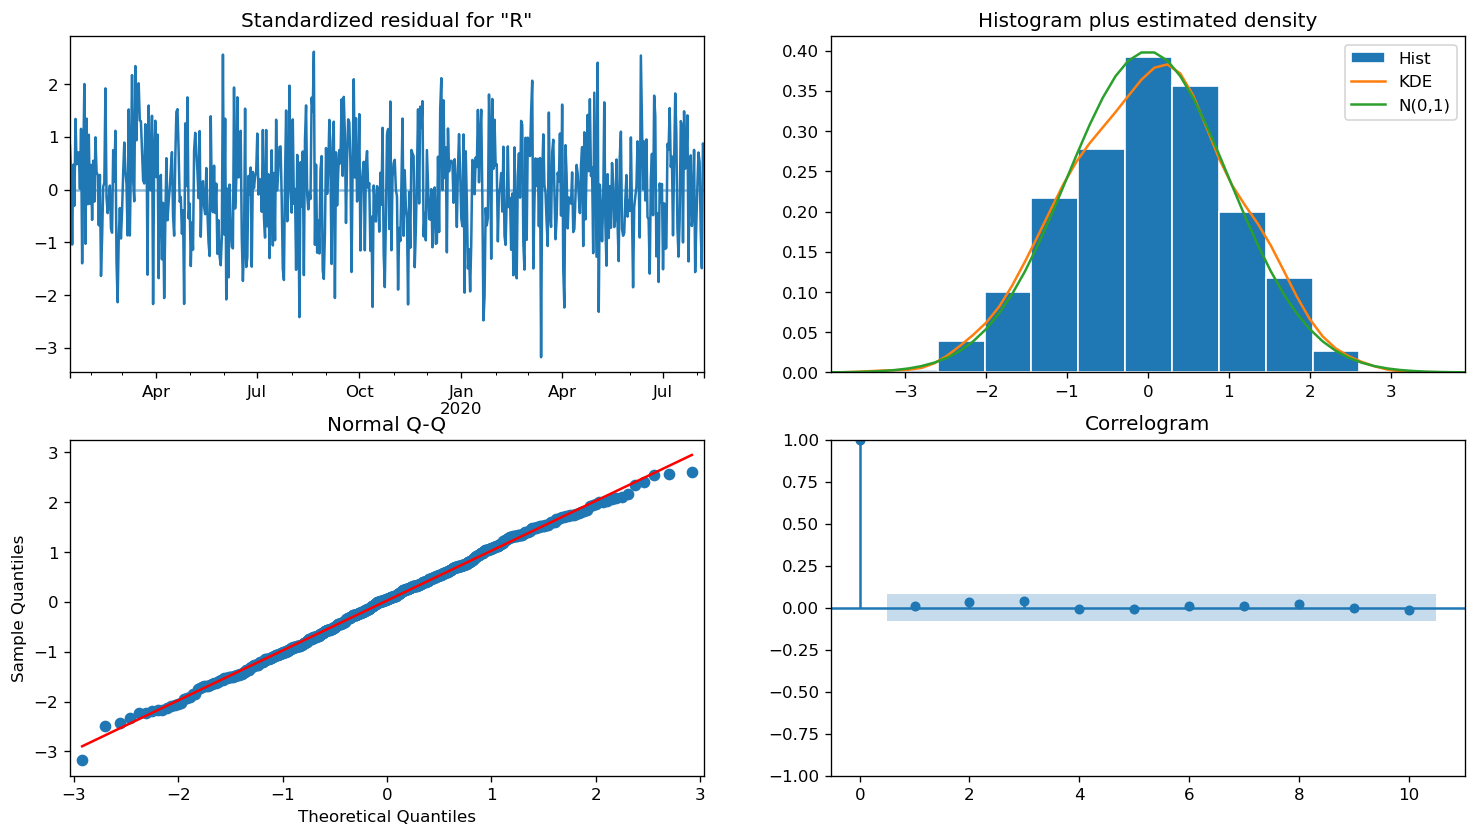

In [22]:
results_train.plot_diagnostics(figsize=(15,8))
plt.show()

### D3. Forecasting using ARIMA Model

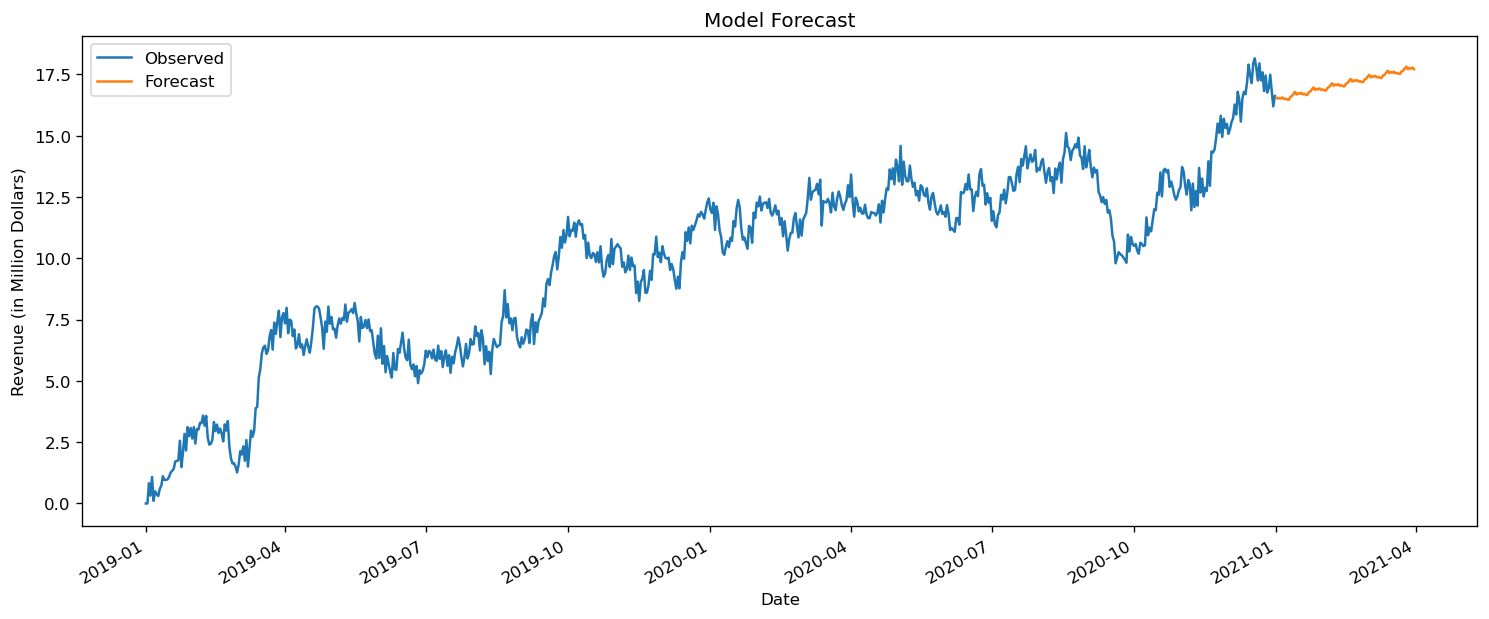

In [23]:
# Get the forecast using the ARIMA model for the next quarter
model = SARIMAX(df['Revenue'],
              order = (3, 0, 1),
              seasonal_order =(2, 1, 1, 12)) 
results = model.fit()
forecast = results.predict(start = len(df),
                           end = (len(df)-1) + 90,
                           typ = 'levels').rename('Forecast')

# Plot the observed values against the forecasted values
plt.plot(df, label='Observed')
plt.xlabel('Date')
plt.ylabel('Revenue (in Million Dollars)')
plt.legend()
forecast.plot(legend = True) 
plt.title('Model Forecast')
plt.show()

In [24]:
print("Forecast for the next quarter's revenue: $",round(sum(forecast),2), "million")

Forecast for the next quarter's revenue: $ 1541.54 million


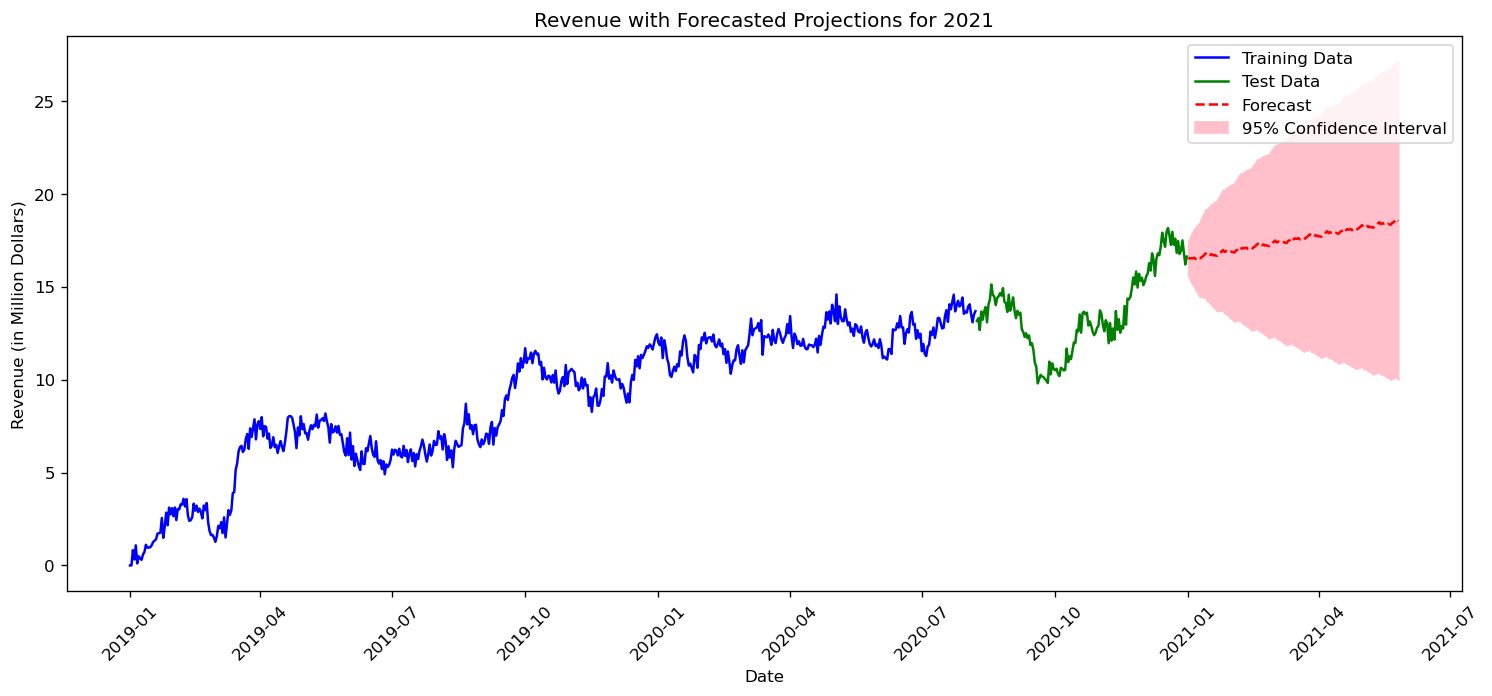

In [25]:
# Forecast 
forecasted = results.get_forecast(steps=146, dynamic=True)

# Calculate the confidence intervals of the predictions
confid_int = forecasted.conf_int()

# Plot the forecasts
plt.plot(X_train, color='blue', label='Training Data')
plt.plot(X_test, color='green', label='Test Data')
plt.plot(forecasted.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(confid_int.index, confid_int['lower Revenue'], confid_int['upper Revenue'], color = 'pink', label='95% Confidence Interval')
plt.plot()
plt.title('Revenue with Forecasted Projections for 2021')
plt.xlabel('Date')
plt.ylabel('Revenue (in Million Dollars)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [26]:
# Extract the observed values from the dataframe
observed_values = df['Revenue'].iloc[-146:].values 

# Extract the forecasted values
forecasted_values = forecasted.predicted_mean.values

# Calculate the root mean squared error 
mse = mean_squared_error(observed_values, forecasted_values)
rmse = (mse)**(1/2) 
print("The calculated Root Mean Squared Error (RMSE) is: " + str(rmse))

The calculated Root Mean Squared Error (RMSE) is: 4.311892261402014


### D4. Output & Calculations
The output and calculations for the analysis can be found above.

### D5. Code
The code used to execute the time series model can be found above.

## Part V: Data Summary & Implications
### E1. Results
- The selection of an ARIMA model: To identify the best suitable ARIMA model, the auto_arima function was executed. This function performed a stepwise search to minimize the AIC and choose the best model, providing the parameters after it has been executed. SARIMAX(3, 0, 1)x(2, 1, 1, 12) with an AIC of 1150.713 were the parameters chosen by this function.

- The prediction interval of the forecast: Since the Revenue dataset was provided with daily revenue data, the ARIMA model was also built with daily values as well to show the forecast for the next quarter.

- A justification of the forecast length: The model is able to predict a maximum of one year. To answer the original research question, I chose the forecast length to be 90 days (one quarter of the next year). I also wanted to take advantage of the two years of data provided, so I also wanted to make use of 20% of the dataset as shown in part D3 on the “Revenue with Forecasted Projections in 2021” graph.

- The model evaluation procedure and error metric: Since the auto_arima function was used, the model evaluation procedure was based on the lowest AIC and to find the suitable seasonal order. For the error metric, the root mean squared error (RMSE) was calculated. The RMSE for the model was 4.3119. This means the predicted values are about 4 units off by from the actual values. A lower RMSE typically represents a  better fit model. However, since we have a fairly large dataset, this value is considered a good value.

### E2. Annotated Visualization

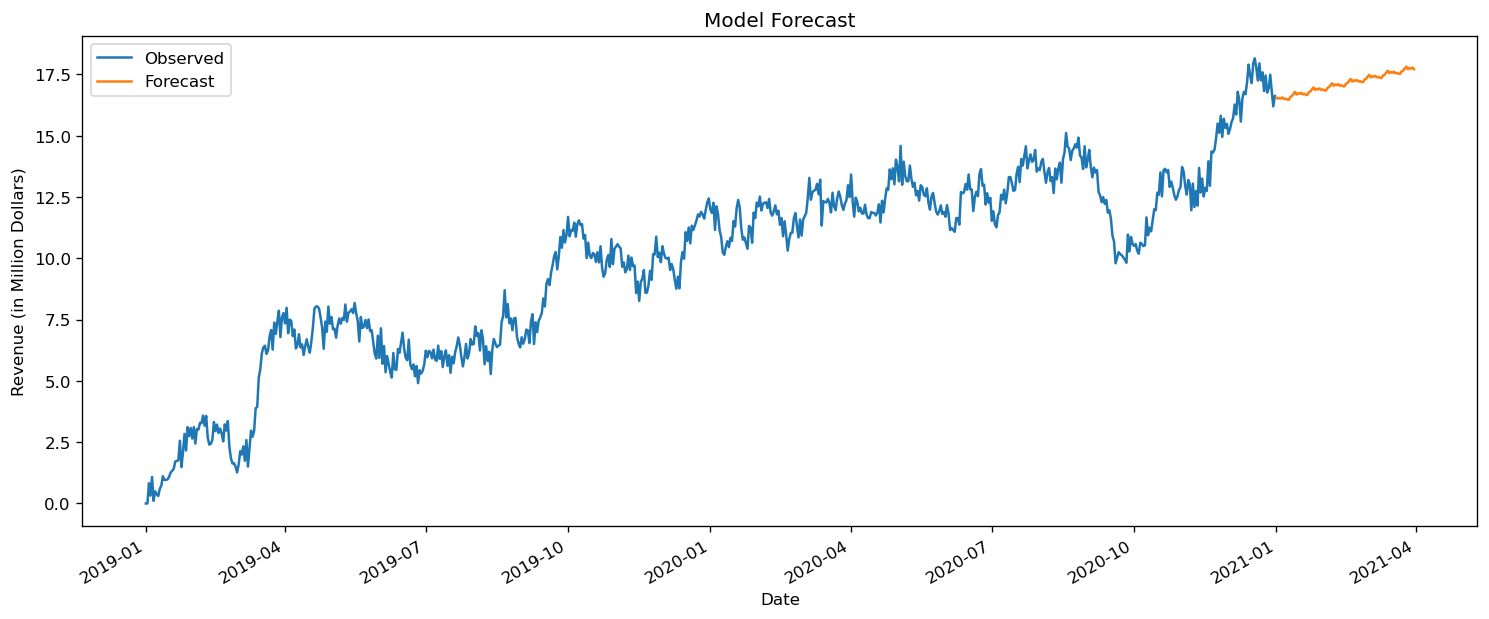

In [27]:
# Get the forecast using the ARIMA model for the next quarter
model = SARIMAX(df['Revenue'],
              order = (3, 0, 1),
              seasonal_order =(2, 1, 1, 12)) 
results = model.fit()
forecast = results.predict(start = len(df),
                           end = (len(df)-1) + 90,
                           typ = 'levels').rename('Forecast')

# Plot the observed values against the forecasted values
plt.plot(df, label='Observed')
plt.xlabel('Date')
plt.ylabel('Revenue (in Million Dollars)')
plt.legend()
forecast.plot(legend = True) 
plt.title('Model Forecast')
plt.show()

### E3. Recommendations
Based on the results of the analysis, time series has a good performance accuracy to forecast the next quarter’s revenue. To answer the research question, it is possible to predict the daily revenue for the next quarter of the telecommunications company based on the daily revenue from the first two years of operation. To do so, I found the sum of the forecasted daily revenue for the next 90 days generated by the ARIMA model which equals $1541.54 million. This shows the model can be utilized by the company to forecast the telecommunications revenue projections.

## Part VI: Reporting
### F. Reporting
Jupyter Notebook was used to execute the time series model. I have attached the HTML document of the executed notebook presentation.

### G. Sources for Third-Party Code
Elleh, F. Advanced Data Analytics - Task 1 [PowerPoint Slides]. (Elleh, n.d.)

### H. Sources
Elleh, F. Advanced Data Analytics - Task 1 [PowerPoint Slides].

### I. Professional Communication